<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Features-to-add" data-toc-modified-id="Features-to-add-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Features to add</a></span></li></ul></div>

Here I am merging tables onto the main table, transfers.

## Features to add

Adding for sure:

- Prescriptions, which is ready

- Admissions: check ppoint, non-white?, marital status??, medicaid, language?

- Patients: Age and gender

- POE: Many categories (order type), but decent. 


Maybe adding in the future:

- Procedures by ICD code, could be interesting but lots of features

- Lab events: A LOT of features, although you can just add flag (associated with storetime) and priority (associated with charttime of test (frequency encoding?)

- OMR: Blood pressure, weight... Interesting but probably there will be many missing values and will be hard to incorporate into dataframe

- hcpcsevents: A LOT of features

- Microbiology events: A LOT of features (no outcomes clear, although there are comments of test)


<br><br>

Some questions: 

Should I increase the granularity of the prescriptions (go down to level 2, 3 or 4). That would add between 1K and 5K features

Can I leave duration of transfer in datetime or should I categorise it/bin it?
bin

Should I bin age or can be quantitative?
Bin it (maybe check before when it's quantitative)

Is it okay adding POE? Should I stop there or add also the other tables? It would mean lots of features. 

Should I add measures such as blood pressure and weight even if values will be missing in many rows? And again do I have to bin?
Leave it for now and maybe with the PCA it tells you something. Maybe you see that could be good to include

Focus on not adding any extra features but focus on step 1 (do PCA, fit models and decide whether to add more features or not)

Step 1
For small dataset
logistic regression SVM, decision tree and random forest, naive bayes
Group the classes before fitting the model
PCA to see if I can compress the model as it is right now
See if by going up on the number of features you are getting any gain
How many orders for now and that's it

Step 2
For large dataset

For dataset try to make bins if possible, 5-10

Distribution is skewed. But after we have converted (the class) into binary, the problem we have is bias (the model is biased).

In [2]:
import numpy as np
import pandas as pd
import copy
import nachopy
import importlib
import pickle
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg'] # Setting plots as vector images

plt.rcParams['figure.figsize'] = (10, 5)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib as mpl
import seaborn as sns

In [3]:
importlib.reload(nachopy)

<module 'nachopy' from 'C:\\Users\\Nacho\\Capstone-project-Brainstation\\nachopy.py'>

In [4]:
transfers = pd.read_pickle('../Capstone data/pickles/transfers_v1.pkl')

In [5]:
transfers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052952 entries, 33258284 to 30249304
Data columns (total 31 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   subject_id          1052952 non-null  int64         
 1   eventtype           1052952 non-null  object        
 2   careunit            1052952 non-null  object        
 3   intime              1052952 non-null  datetime64[ns]
 4   outtime             1052952 non-null  datetime64[ns]
 5   event               1052952 non-null  object        
 6   gender              1052952 non-null  object        
 7   anchor_age          1052952 non-null  uint8         
 8   dod                 263671 non-null   datetime64[ns]
 9   hadm_id             1034425 non-null  Int64         
 10  admission_type      1034425 non-null  object        
 11  discharge_location  940809 non-null   object        
 12  insurance           1034425 non-null  object        
 13  lang

In [6]:
transfers.event.value_counts()

Discharge                                           432373
Medicine                                            114133
Emergency Department Observation                     85074
Med/Surg                                             35544
Medicine/Cardiology                                  29622
Neurology                                            29128
Discharge Lounge                                     28846
PACU                                                 23218
Med/Surg/GYN                                         19592
Vascular                                             19261
Medical Intensive Care Unit (MICU)                   19214
Med/Surg/Trauma                                      18880
Transplant                                           18804
Hematology/Oncology                                  16295
Obstetrics (Postpartum & Antepartum)                 14621
Medical/Surgical Intensive Care Unit (MICU/SICU)     13794
Surgical Intensive Care Unit (SICU)                  132

In [7]:
# Removing unknowns
transfers.loc[(transfers.event=='Unknown'),'event'] = 'Discharge'

In [8]:
transfers.loc[transfers.event.str.contains(\
    'Gynecology|Obstetrics|Labor| Antepartum|Obstetrics (Postpartum & Antepartum)','Gynecology & Obstetrics',\
    regex = True),'event'] = 'Gynecology, Obstetrics & Labor'

transfers.loc[transfers.event.str.contains('Neuro'),'event'] = 'Neuro'
transfers.loc[transfers.event.str.contains('Trauma'),'event'] = 'Trauma'
transfers.loc[transfers.event.str.contains('Cardi|Coronary'),'event'] = 'Cardiac'
transfers.loc[transfers.event.str.contains('SICU|MICU'),'event'] = 'MICU/SICU'
transfers.loc[transfers.event.str.contains('Surgery'),'event'] = 'General surgery'
transfers.loc[transfers.event.str.contains('Discharge'),'event'] = 'Discharge'
transfers.loc[transfers.event.str.contains('Observation|Emergency'),'event'] = 'Emergency Department Observation'
transfers.loc[transfers.event.str.contains('General surgery'),'event'] = 'Med/Surg'
transfers.loc[transfers.event.str.contains('Oncology'),'event'] = 'Hematology/Oncology'
transfers.loc[transfers.event.str.contains('Psychiatry'),'event'] = 'Neuro'

transfers.loc[~transfers.discharge_location.isna(),'event'] = transfers.event.\
    where(~(transfers.event == 'Discharge'),transfers.discharge_location)
transfers.event.value_counts()

HOME                                211146
Medicine                            114133
HOME HEALTH CARE                     96022
Emergency Department Observation     88217
Cardiac                              73502
SKILLED NURSING FACILITY             53981
Discharge                            52535
Med/Surg                             50820
MICU/SICU                            46286
Trauma                               42394
Gynecology, Obstetrics & Labor       37774
Neuro                                36559
PACU                                 23218
Hematology/Oncology                  21066
Med/Surg/GYN                         19592
Vascular                             19261
Transplant                           18804
REHAB                                12305
DIED                                 10056
CHRONIC/LONG TERM ACUTE CARE          8401
AGAINST ADVICE                        4460
HOSPICE                               3968
PSYCH FACILITY                        3591
OTHER FACIL

Happily most patients went home, although some died. We will group a few of these

In [9]:
transfers.loc[transfers.event.str.contains('ACUTE|FACILITY|PSYCH|REHAB|ASSISTED'),'event'] = 'Other facility'
transfers.loc[transfers.event.str.contains('HOSPICE'),'event'] = 'DIED'
transfers.loc[transfers.event.str.contains('AGAINST|Discharge'),'event'] = 'Other discharge'
transfers.event.value_counts()

HOME                                211146
Medicine                            114133
HOME HEALTH CARE                     96022
Emergency Department Observation     88217
Other facility                       83139
Cardiac                              73502
Other discharge                      56995
Med/Surg                             50820
MICU/SICU                            46286
Trauma                               42394
Gynecology, Obstetrics & Labor       37774
Neuro                                36559
PACU                                 23218
Hematology/Oncology                  21066
Med/Surg/GYN                         19592
Vascular                             19261
Transplant                           18804
DIED                                 14024
Name: event, dtype: int64

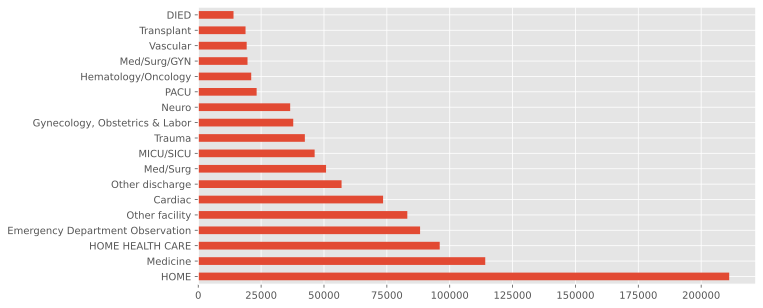

In [94]:
fig = plt.figure()
transfers.event.value_counts().plot.barh()
plt.show()
fig.savefig('rowsperclass.svg',bbox_inches='tight')

In [10]:
transfers.race.value_counts()

WHITE                                        656177
BLACK/AFRICAN AMERICAN                       145096
OTHER                                         37013
UNKNOWN                                       27709
HISPANIC/LATINO - PUERTO RICAN                22377
WHITE - OTHER EUROPEAN                        21196
ASIAN                                         14764
ASIAN - CHINESE                               14375
WHITE - RUSSIAN                               14327
HISPANIC OR LATINO                            12548
BLACK/CAPE VERDEAN                            12467
HISPANIC/LATINO - DOMINICAN                   11940
BLACK/CARIBBEAN ISLAND                         7021
BLACK/AFRICAN                                  6620
PORTUGUESE                                     3838
ASIAN - SOUTH EAST ASIAN                       3748
HISPANIC/LATINO - GUATEMALAN                   3501
UNABLE TO OBTAIN                               3329
WHITE - EASTERN EUROPEAN                       3201
PATIENT DECL

In [11]:
transfers['duration'] = transfers.outtime - transfers.intime

In [12]:
transfers = transfers.join(pd.get_dummies(transfers.gender,drop_first = True,prefix = 'gender_')).drop(columns = 'gender')
transfers = transfers.join(pd.get_dummies(transfers.race)['WHITE'])
transfers = transfers.join(pd.get_dummies(transfers.language)['ENGLISH'])
transfers = transfers.join(pd.get_dummies(transfers.marital_status,drop_first=True)).drop(columns = 'marital_status')
transfers = transfers.join(pd.get_dummies(transfers.insurance,drop_first=True)).drop(columns = 'insurance')
transfers = transfers.join(pd.get_dummies(transfers.admission_type,drop_first=True)).drop(columns = 'admission_type')

In [13]:
transfers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052952 entries, 33258284 to 30249304
Data columns (total 44 columns):
 #   Column                       Non-Null Count    Dtype          
---  ------                       --------------    -----          
 0   subject_id                   1052952 non-null  int64          
 1   eventtype                    1052952 non-null  object         
 2   careunit                     1052952 non-null  object         
 3   intime                       1052952 non-null  datetime64[ns] 
 4   outtime                      1052952 non-null  datetime64[ns] 
 5   event                        1052952 non-null  object         
 6   anchor_age                   1052952 non-null  uint8          
 7   dod                          263671 non-null   datetime64[ns] 
 8   hadm_id                      1034425 non-null  Int64          
 9   discharge_location           940809 non-null   object         
 10  language                     1034425 non-null  object     

<AxesSubplot: ylabel='event'>

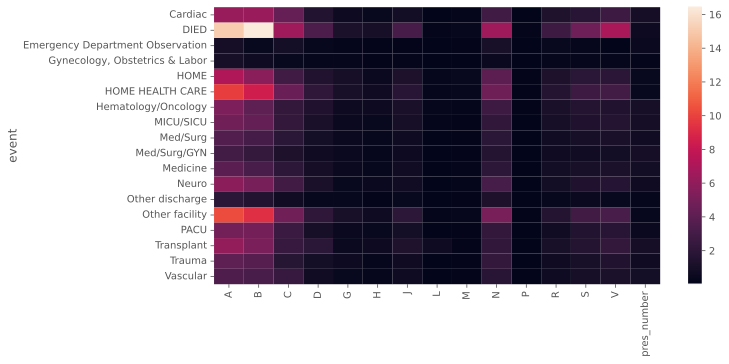

In [49]:
sns.heatmap(pres_dfs.groupby('event').mean())

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(transfers.event)
transfers_y = le.transform(transfers.event)

In [15]:
X_cols = list(transfers.columns[12:])
transfers['duration'] = transfers.duration/np.timedelta64(1,'h')

In [16]:
X_cols.append('anchor_age')

In [17]:
from sklearn.model_selection import train_test_split
transfers_X = transfers[X_cols].reset_index(drop = True)

X_train, X_test, y_train, y_test = train_test_split(
    transfers_X, transfers_y, stratify = transfers_y, random_state = 42, test_size = 0.3
)



In [44]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C = 0.1)

LR.fit(X_train,y_train)

print(LR.score(X_train,y_train))
print(LR.score(X_test,y_test))

0.26779148678680065
0.26693174119777385


In [29]:
np.isnan(y_train).any()

False

In [31]:
y_train

array([10,  0, 10, ...,  4, 15,  2])

In [32]:
X_train.reset_index(drop = True, inplace = True)

In [46]:
# Importing functions and classes
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV # Grid search tool to try multiple parameters and models
from sklearn.decomposition import PCA

cv = None # Typically 10, ºsomething that would be okay for this dataset as it is large enough, but set as 5 for speed 

# Defining paipeline
# In our pipeline, the data will be normalised before a logistic regression is fitted 
estimators = [('scaler', StandardScaler()),
              ('model',LogisticRegression())] # And logistic regression only (as specified in grid as well)

pipe = Pipeline(estimators)
# Defining parameter grid

n_range = [5,10,15]
C_range = np.logspace(-2,2,num = 5) # Setting range of 9 C values for regularisation from 0.001 to 10,000

param_grid = [
    {
        'scaler':[StandardScaler()], # Normalisations
        'model':[LogisticRegression()], # Model
        'model__C':C_range, # Regularisation parameter
    }
]

# Creating grid using 10 folds (this is the standard and we have enough data so that the training set will not be too small)
grid_logreg = GridSearchCV(pipe, param_grid, cv = cv)
# Fitting grid (or models)
logreg_fitted_grid = grid_logreg.fit(X_train, y_train)
display(logreg_fitted_grid.best_estimator_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=10.0))])

In [68]:
min(y_train)

0

In [72]:
labels = le.inverse_transform(np.arange(18))

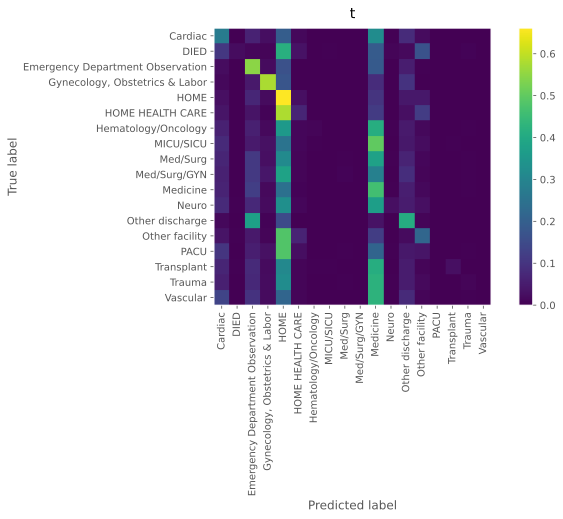

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay
 

fig1 = ConfusionMatrixDisplay.from_estimator(logreg_fitted_grid, X_test, y_test, normalize = 'true', include_values = False,\
                                      display_labels = labels)
plt.xticks(rotation = 90)
plt.grid(False)
plt.title('t',pad = 10)
plt.show()
fig1.figure_.savefig('confusion.svg',bbox_inches='tight')

In [78]:
import pickle

In [79]:
logreg_out = open('../Capstone data/pickles/logreg_caca.pkl','wb')
pickle.dump(logreg_fitted_grid,logreg_out)
logreg_out.close()

Best model's CV score: 0.3167369001746495
Best model's test score 0.3161741894227664
Baseline model (score of a model that always predicts 1) 7.201474582602584


ValueError: Expected 'estimator' to be a binary classifier, but got GridSearchCV fit on multiclass (18 classes) data

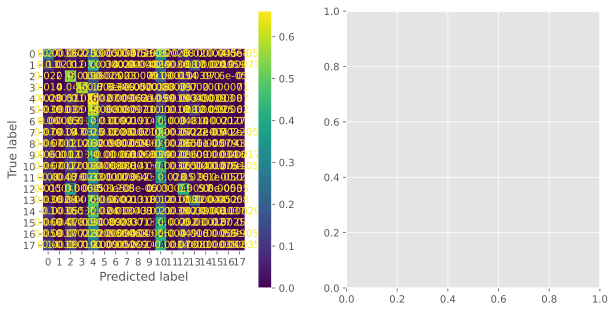

In [53]:
nachopy.roc_n_confusion(logreg_fitted_grid,X_test,y_test)

In [76]:
transfers_tr = X_train.copy()
transfers_tr['event'] = le.inverse_transform(y_train)

In [77]:
cat = list('ABCDGHJLMNPRSV')

In [78]:
cat.append('pres_number')

In [79]:
cat.append('event')


In [80]:
pres_dfs = transfers_tr[cat].copy()

In [81]:
pres_dfs[['A','B']].div(transfers_tr.duration,axis = 0)

,A,B
475226,0.000000,0.000000
974582,0.000000,0.000000
176044,0.736460,0.368230
205139,0.096104,0.168183
140725,0.000000,0.000000
...,...,...
857794,0.241935,0.120968
536965,0.297918,0.297918
867031,0.000000,0.000000
567949,0.315411,0.315411


In [83]:
pres_dfs[pres_dfs.columns[:-1]]= pres_dfs[pres_dfs.columns[:-1]].div(transfers_tr.duration,axis = 0)

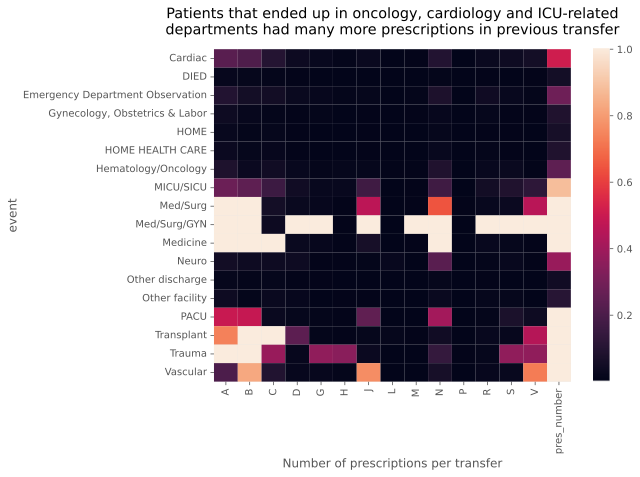

In [87]:
fig1 = plt.figure(figsize = (8,6))
sns.heatmap(pres_dfs.groupby('event').mean(),vmax = 1)
plt.title('Patients that ended up in oncology, cardiology and ICU-related\ndepartments had many more prescriptions in previous transfer',pad = 15)
plt.xlabel('Number of prescriptions per transfer')
fig1.savefig('prespertransfervsunit.svg',bbox_inches='tight')

In [ ]:
fig2 = plt.figure(figsize = (10,8))
sns.heatmap(catsperevent.divide(presperevent, axis = 0)*100,cmap='viridis',xticklabels= True)
plt.title('Patients that ended up in different departments were prescribed\ndifferent types of drugs',pad = 15)
plt.xlabel('Number of prescriptions per transfer')
fig2.savefig('drugtypesvcareunit.svg',bbox_inches='tight')

In [ ]:
cat = list('ABCDGHJLMNPRSV')
cat.append('event')
catsperevent = transfers[cat].groupby('event')
catsperevent = catsperevent.sum()/catsperevent.count().sort_index()
presperevent = catsperevent.sum(axis = 1).sort_index(ascending = False)

fig,_ = plt.subplots(2,1,figsize = (8,15))

plt.subplot(2,1,1)
presperevent.sort_values().plot.barh()

plt.subplot(2,1,2)
sns.heatmap(catsperevent.divide(presperevent, axis = 0)*100,cmap='viridis')

plt.show()


In [ ]:
cat = list('ABCDGHJLMNPRSV')
cat.append('event')
catsperevent = transfers[cat].groupby('event')
catsperevent = catsperevent.sum()/catsperevent.count()

Okay, heatmap probably relevant, but I need to normalise the number of prescriptions per event by the duration of the stay

In [ ]:
tran

In [ ]:
poe = pd.read_csv('../Capstone data/MIMIC IV/poe.csv')

In [ ]:
transfers[cat]

In [ ]:
poe.order_type.value_counts(normalize = True)


In [ ]:
cap_utils.display_sbs(['Order subtype value counts'],poe.order_subtype.value_counts(normalize = True))

Probably dropping medications? Could add order sub type and filling the empty values (loads) with the simple order type?

In [ ]:
ed_dupl = edstays.drop(columns = 'stay_id').duplicated()
print(ed_dupl.sum())
edstays = edstays[~ed_dupl]

In [ ]:
edstays.info()

In [ ]:
uniqueid_set = set(transfers.hadm_id.unique())
hadm_len = len(uniqueid_set)
unique_stayid = edstays.stay_id.unique()
stay_len = len(unique_stayid)
set_len = 0
i = 0
while (len(uniqueid_set) > set_len) & (i<stay_len):
    set_len = len(uniqueid_set)
    uniqueid_set.add(unique_stayid[i])
    i +=1
if set_len == hadm_len + stay_len-1:
    print('All good')
else:
    print('caca')

In [ ]:
edstays = edstays[['subject_id','stay_id','intime','outtime']]

In [ ]:
edstays.info()

In [ ]:
edstays['intime'] = pd.to_datetime(edstays.intime,infer_datetime_format=True)
edstays['outtime'] = pd.to_datetime(edstays.outtime,infer_datetime_format=True)

In [ ]:
ed_dupl = edstays.drop(columns = 'stay_id').duplicated()
print(ed_dupl.sum())
edstays = edstays[~ed_dupl]

In [ ]:
transfers = transfers.merge(
                        edstays,
                        left_on = ['subject_id','intime','outtime'], 
                        right_on = ['subject_id','intime','outtime'],
                        how = 'left',
                        copy = False)

In [ ]:
transfers.loc[transfers.hadm_id.isna(),'hadm_id'] = transfers.loc[transfers.hadm_id.isna(),'stay_id']
sum(transfers.hadm_id.isna())

In [ ]:
transfers.careunit.value_counts()

In [ ]:
cat_pres.A.value_counts(normalize = True)*100

In [ ]:
unclass_drugs = cat_pres.drug[cat_pres.A<0].drop_duplicates()
udrugs_gsnvc = cat_pres.gsn[cat_pres.A<0].value_counts()
gsn_udrugs = udrugs_gsnvc[udrugs_gsnvc>1].index.values

In [ ]:
cat.append('gsn')
cat_gsn = cat_pres.loc[cat_pres.gsn.isin(gsn_udrugs),cat].groupby('gsn').max()
cat_gsn = cat_gsn[cat_gsn.A>-1]
cat_gsn

In [ ]:
cat = cat[:-1]
cat_pres[cat] = cat_pres[cat].where(cat_pres[cat]>=0)

In [ ]:
cat_pres.set_index(ind,append = True)

In [ ]:
cat_pres.set_index('gsn', inplace = True)
cat_pres.update(cat_gsn)
cat_pres.set_index(ind)

In [ ]:
cat_pres.head()

In [ ]:
sum(cat_pres.drug.str.contains('polyvalent'))

In [ ]:
cat_pres.gsn[misspelt_drugs_bool].value_counts().describe()

In [ ]:
(5303415+7791711)/len(cat_pres)

In [ ]:
cat

In [ ]:
cat = list('ABCDGHJLMNPRSV')
cat.append('drug')
cat_drug = cat_pres[cat].fillna(0.0001).groupby('formulary_drug_cd',dropna = False).sum()
cat_drug

In [ ]:
atr4_pres.atc4_name.nunique()

The missing values labelled as 0 are now empty strings due to the conversion. There may be other values that are not 0, maybe even some could be in other ndc formats (hyphenated or with less digits). We can find out how many rows have which number of digits.

So all fields that do not have 9-digit numbers have no digits. We can consider all of these as missing values.

More than 12% of ndc fields are missing. Some of the drugs listed here may not have an ndc (Sodium Chloride flush on 2nd row for instance), but others may be mistakes. NDC is specific to product, not to drug (same drug from different companies will have a different code) so filling from the table would not be very accurate. Given that what we need the NDC just to classify our drugs, we will leave these fields blank and will fill the categories instead after NDC-matching.


In [ ]:
prescriptions.ndc[~missing_ndc].drop_duplicates().to_csv('Unique_NDCs.csv')

Let us see if we can fill these missing values by using the other fields in the table. pharmacy_id, gsn, drug and formulary_drug_cd could be used for this.

In [ ]:
prescriptions.formulary_drug_cd.info()

In [ ]:
fdrugna = prescriptions[prescriptions.formulary_drug_cd.isna()]

In [ ]:
def df_filler(x):
    

prescriptions.formulary_drug_cd[prescriptions.drug.isin(fdrugna.drug)].isna()

In [ ]:
prescriptions.gsn.value_counts()

In [ ]:
prescriptions.pharmacy_id.value_counts()

In [ ]:
prescriptions.formulary_drug_cd.value_counts()

In [ ]:
prescriptions.formulary_drug_cd.info()

In [ ]:
prescriptions.drug = prescriptions.drug.str.lower()
prescriptions.drug.value_counts().describe()

In [ ]:
ndc_bool = prescriptions.ndc!=u'' & prescriptions 
print(sum(ndc_bool))
print(sum(~ndc_bool))

In [ ]:
elswhr_bool = prescriptions.loc[~ndc_bool,'drug'].isin(prescriptions.loc[ndc_bool,'drug'])
print(round(sum(elswhr_bool)/sum(~ndc_bool)*100,2))

In [ ]:
prescriptions.loc[elswhr_bool,'ndc'] = prescriptions.loc[ndc_bool*prescriptions.,'ndc']

In [ ]:
prescriptions.ndc.nunique()

In [ ]:
import numpy as np

In [ ]:
medication = pd.read_json(r'C:\Users\Nacho\Downloads\Medication.ndjson', lines = True)

In [ ]:
medication.shape

In [ ]:
prescriptions.ndc.head()

In [ ]:
ndc_desc = pd.read_csv("G:\My Drive\Brainstation\Capstone project\product.csv",usecols = ['PRODUCTNDC','NONPROPRIETARYNAME','PHARM_CLASSES'])

In [ ]:
ndc_desc = ndc_desc.loc[~ndc_desc.PHARM_CLASSES.isna()].reset_index(drop = True)

In [ ]:
ndc_desc.head()

In [ ]:
def sht2nineNDC(x):
    x = x.split('-')
    x = x[0].zfill(5) + x[1].zfill(4)
    
    return x
    

ndc_desc.PRODUCTNDC = ndc_desc.PRODUCTNDC.apply(sht2nineNDC)

In [ ]:
ndc_desc.PRODUCTNDC.head()

In [ ]:
classpername = ndc_desc[['NONPROPRIETARYNAME','PHARM_CLASSES']].groupby('NONPROPRIETARYNAME').nunique()

In [ ]:
classperndc = ndc_desc[['PRODUCTNDC','PHARM_CLASSES']].groupby('PRODUCTNDC').nunique()

In [ ]:
classpername.value_counts()

In [ ]:
classperndc.value_counts()

In [ ]:
np.mean(prescriptions.ndc.isna())*100

In [ ]:
prescriptions.loc[prescriptions.ndc.isna()].head(10)

In [ ]:
ndc_desc.rename(columns = {'PRODUCTNDC' : 'ndc'},inplace = True)

In [ ]:
presfinal = pd.merge(prescriptions,ndc_desc, how = 'left',on = 'ndc')

In [ ]:
np.mean(presfinal.PHARM_CLASSES.isna())

In [ ]:
np.mean(presfinal.NONPROPRIETARYNAME.isna())

In [ ]:
presfinal[['ndc','drug','NONPROPRIETARYNAME','PHARM_CLASSES']]

In [ ]:
presfinal.hadm_id.nunique()

In [ ]:
len(presfinal.PHARM_CLASSES.isna())-sum(presfinal.PHARM_CLASSES.isna())

In [ ]:
classperhadm = presfinal[['PHARM_CLASSES','hadm_id']].groupby('hadm_id').nunique()
classperhadm.describe()

In [ ]:
classperhadm.loc[classperhadm.PHARM_CLASSES == 0].count()

In [ ]:
prescriptions.ndc.apply(lambda x: str(x)[:-2].zfill(9))

In [ ]:
print(ndc_desc.NONPROPRIETARYNAME.nunique())
print(ndc_desc_clean.NONPROPRIETARYNAME.nunique())

In [ ]:
ndc_desc.shape

In [ ]:
ndc_desc.PRODUCTNDC.apply(lambda x: int(x.replace('-','')))

In [ ]:
ndc_desc.PHARM_CLASSES.value_counts

In [ ]:
poe = pd.read_csv('MIMIC IV ED/poe.csv')

In [ ]:
poe.order_status.value_counts(normalize = True)

In [ ]:
poe.loc[poe.order_type == 'Lab'].order_subtype.value_counts()

In [ ]:
poe.order_type.value_counts()

In [ ]:
admissions = pd.read_csv('MIMIC IV ED/admissions.csv')

In [ ]:
admissions.race.value_counts(normalize = True)

In [ ]:
sum(admissions.admission_location.isna())

In [ ]:
admissions.admission_location.value_counts(normalize = True)

In [ ]:
transfers = pd.read_csv('MIMIC IV ED/transfers.csv')

In [ ]:
sum(transfers.eventtype == 'discharge')

In [ ]:
transfers.careunit.value_counts(normalize = True)

In [ ]:
transfers.careunit.unique()

In [ ]:
transfers[['intime','outtime']] = pd.to_datetime(transfers[['intime', 'outtime']])

In [ ]:
transfers.info(show_counts = True)

In [ ]:
bool_outs

In [ ]:
transfers.describe()

In [ ]:
bool_discharge = transfers.eventtype=='discharge'
bool_carenan = transfers.careunit.isna()
bool_outtime = transfers.outtime.isna()

In [ ]:
print(all(bool_discharge == bool_carenan))
print(all(bool_discharge == bool_outtime))


In [ ]:
transfers.head()

In [ ]:
services = pd.read_csv('MIMIC IV ED/services.csv')

In [ ]:
services.shape

In [ ]:
services.head()

In [ ]:
services.prev_service.value_counts()

In [ ]:
transfers.eventtype.value_counts()

In [ ]:
transfers.

In [ ]:
emar = pd.read_csv('MIMIC IV/emar.csv')

In [ ]:
emar.medication.nunique()

In [ ]:
emar.head()

In [ ]:
transfers.careunit.value_counts()

In [ ]:
print('Number of patients:',transfers['subject_id'].nunique())
print('Number of transfers (and rows number):',transfers['transfer_id'].nunique())
print('Number of stays:',transfers['hadm_id'].nunique())
print('Number of departments:',transfers['careunit'].nunique())

In [ ]:
sum(transfers['careunit'].isna())

In [ ]:
print('Number of departments:',transfers['careunit'].unique())

In [ ]:
admissions = pd.read_csv('MIMIC IV ED/admissions.csv')

In [ ]:
pd.to_datetime(admissions.admittime,infer_datetime_format = True).describe(datetime_is_numeric = True)

In [ ]:
admissions.discharge_location.unique()

In [ ]:
admissions.head()

In [ ]:
len(admissions)

In [ ]:
print('Number of patients:',admissions['subject_id'].nunique())
print('Number of transfers (and length of rows):',admissions['transfer_id'].nunique())
print('Number of stays:',transfers['hadm_id'].nunique())
print('Number of departments:',transfers['careunit'].nunique())

In [ ]:
edstays['disposition'].value_counts()

In [ ]:
diagnosis.icd_version.value_counts()

In [ ]:
diagnosis['icd_title'].value_counts().head()

In [ ]:
print('\033[1m' + 'diagnosis')
display(diagnosis.head())
display(diagnosis.info())
print('\033[1m' + 'edstays')
display(edstays.head())
display(diagnosis.info())
print('\033[1m' + 'medrecon')
display(medrecon.head())
display(medrecon.info())
print('\033[1m' + 'pyxis')
display(pyxis.head())
display(pyxis.info())
print('\033[1m' + 'triage')
display(triage.head())
display(triage.info())
print('\033[1m' + 'vitalsign')
display(vitalsign.head())
display(vitalsign.info())